# Deer detection

This notebook uses the data from the following hugging face dataset "myyyyw/NTLNP" to train a small YoloV8 model to detect deer in images.

The training_data folder contains the downloaded data from the dataset, which has been extracted from the rar files.

In [1]:
retrain = False
is_in_colab = False
project_name = 'deer_detection'

In [2]:
# For Google Colab
if is_in_colab:
    !git lfs install
    !git clone https://huggingface.co/datasets/myyyyw/NTLNP

In [3]:
if is_in_colab:
    ! pip install huggingface_hub patool pylabel transformers pytorch_lightning

In [4]:
import wandb


wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: whitew1994. Use `wandb login --relogin` to force relogin


True

In [5]:
# Download the hugging face dataset 'myyyyw/NTLP' and save it in the folder 'training_data'
import patoolib
import os
if os.path.exists('training_data'):
    data_folder = 'training_data'
else:
    data_folder = 'NTLNP'
filenames = ['voc_day.rar', 'voc_night.rar']


# Extract the two rar files
for rar_file in filenames:
    if os.path.exists(os.path.join(data_folder, rar_file.split('.')[0])):
        print(f'{rar_file} already extracted')
    else:
        patoolib.extract_archive(os.path.join(data_folder, rar_file), outdir=data_folder)

voc_day.rar already extracted
voc_night.rar already extracted


In [6]:
dataset_already_extracted = False 
if os.path.exists(os.path.join(data_folder, 'coco_train.json')):
    dataset_already_extracted = True
    print('Dataset already extracted')

Dataset already extracted


In [7]:
from pylabel import importer
import pandas as pd
if not dataset_already_extracted:
    day_annotation_folder = f'./{data_folder}/voc_day/Annotations/'
    night_annotation_folder = f'./{data_folder}/voc_night/Annotations/'

    path_to_images = "../JPEGImages/"

    day_dataset = importer.ImportVOC(path=day_annotation_folder, path_to_images=path_to_images)
    night_dataset = importer.ImportVOC(path=night_annotation_folder, path_to_images=path_to_images)

    datasets = {
        "day": day_dataset,
        "night": night_dataset
    }

In [8]:
if not dataset_already_extracted:
    cat_mapping = dict(zip(datasets["day"].df['cat_id'].unique(), datasets["day"].df['cat_name'].unique()))

    # Apply the same mapping to the night dataset
    datasets["night"].df['cat_name'] = datasets["night"].df['cat_id'].map(cat_mapping)
    datasets["night"].df['cat_id'] = datasets["night"].df['cat_name'].map(dict(zip(datasets["night"].df['cat_name'].unique(), datasets["night"].df['cat_id'].unique())))

    night_cat_mapping = dict(zip(datasets["night"].df['cat_id'].unique(), datasets["night"].df['cat_name'].unique()))


In [9]:
import copy
if not dataset_already_extracted:
    # Combine the two datasets
    datasets['day'].df['img_folder'] = '.'
    datasets['day'].df['img_filename'] = datasets['day'].df['img_filename'].apply(lambda x: 'voc_day/JPEGImages/' + x)
    datasets['night'].df['img_folder'] = '.'
    datasets['night'].df['img_filename'] = datasets['night'].df['img_filename'].apply(lambda x: 'voc_night/JPEGImages/' + x)
    datasets['combined'] = copy.deepcopy(datasets['day'])
    datasets['combined'].df = pd.concat([datasets['day'].df, datasets['night'].df]).reset_index(drop=True)


    # Update the targets to be 1 for deer and 0 for non deer
    id_to_cat = datasets['combined'].df[['cat_name', 'cat_id']].drop_duplicates().sort_values(by='cat_id').reset_index(drop=True)

    target_classes = id_to_cat[id_to_cat['cat_name'].str.lower().str.contains('deer')]['cat_id'].values
    non_target_classes = id_to_cat[~id_to_cat['cat_name'].str.lower().str.contains('deer')]['cat_id'].values

    print(f"Target classes: {target_classes}")
    print(f"Non target classes: {non_target_classes}")

    datasets['combined'].df['cat_id'] = datasets['combined'].df['cat_id'].apply(lambda x: 1 if x in target_classes else 0)
    datasets['combined'].df['cat_name'] = datasets['combined'].df['cat_id'].apply(lambda x: 'deer' if x == 1 else 'non_deer')


    # Shuffle the combined dataset and split into train val and test sets
    test_size = 0.2
    val_size = 0.1
    train_size = 1 - test_size - val_size

    datasets['combined'].df = datasets['combined'].df.sample(frac=1).reset_index(drop=True)

    for key in ['train', 'val', 'test']:
        datasets[key] = copy.deepcopy(datasets['combined'])
        
    datasets['train'].df = datasets['combined'].df.iloc[:int(train_size*len(datasets['combined'].df))].reset_index(drop=True)
    datasets['val'].df = datasets['combined'].df.iloc[int(train_size*len(datasets['combined'].df)):int((train_size+val_size)*len(datasets['combined'].df))].reset_index(drop=True)
    datasets['test'].df = datasets['combined'].df.iloc[int((train_size+val_size)*len(datasets['combined'].df)):].reset_index(drop=True)



In [10]:
if not dataset_already_extracted:
    for dataset_name, dataset in datasets.items():
        print(f"Dataset: {dataset_name}")
        print(f"Number of images: {dataset.analyze.num_images}")
        print(f"Number of classes: {dataset.analyze.num_classes}")
        print(f"Classes:{dataset.analyze.classes}")
        print(f"Class counts:\n{dataset.analyze.class_counts}")

In [11]:
if not dataset_already_extracted:
    datasets['combined'].export.ExportToCoco(output_path='./training_data/coco_combined.json')
    datasets['train'].export.ExportToCoco(output_path='./training_data/coco_train.json')
    datasets['val'].export.ExportToCoco(output_path='./training_data/coco_val.json')
    datasets['test'].export.ExportToCoco(output_path='./training_data/coco_test.json')


In [12]:
if not dataset_already_extracted:
    # Import the combined dataset
    combined_dataset = importer.ImportCoco(path='./training_data/coco_combined.json')

In [13]:
from IPython.display import Image, display
if not dataset_already_extracted:
    display(combined_dataset.visualize.ShowBoundingBoxes(1000))
    # display(combined_dataset.visualize.ShowBoundingBoxes("BloodImage_00315.jpg"))


In [14]:
import torchvision
import os
from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, set):
        ann_file = os.path.join(img_folder, f"coco_{set}.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super().__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

train_dataset = CocoDetection(img_folder=data_folder, feature_extractor=feature_extractor, set='train')
val_dataset = CocoDetection(img_folder=data_folder, feature_extractor=feature_extractor, set='val')
test_dataset = CocoDetection(img_folder=data_folder, feature_extractor=feature_extractor, set='test')

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of testing examples:", len(test_dataset))

id2label = {k: v['name'] for k,v in train_dataset.coco.cats.items()}


c:\Users\William.White\AppData\Local\miniconda3\envs\lender_approval\lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of training examples: 13020
Number of validation examples: 2556
Number of testing examples: 4923


In [15]:
#Setup dataloader for training loop
if retrain:
  def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['labels'] = labels
    return batch

  train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True, num_workers=1)
  val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1, num_workers=1)
  test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=1, num_workers=1)
  batch = next(iter(train_dataloader))

In [16]:
from yolo_model import YoloS

num_labels = len(id2label)

In [17]:
if retrain:
    gpu_available = torch.cuda.is_available()

    if not hasattr(torch._C, "_cuda_getDeviceCount"):
        raise("CUDA not compiled in PyTorch. Training on CPU")

    if not gpu_available:
        raise("No GPU available. Training on CPU")

In [24]:
experiment_name = 'yolo-tiny-deer-non-deer'
if retrain:
    model = YoloS(lr=2.5e-5, weight_decay=1e-4, num_labels=num_labels, train_dataloader=train_dataloader, val_dataloader=val_dataloader, test_dataloader=test_dataloader)
    
    # Keep track of the checkpoint with the lowest validation loss
    checkpoint_callback = ModelCheckpoint(monitor="validation/loss", mode="min", dirpath="checkpoints", filename=experiment_name)
    checkpoint_filename = checkpoint_callback.dirpath + '/' + checkpoint_callback.filename + '.ckpt'
    # CLear out the checkpoints folder
    if os.path.exists(checkpoint_callback.dirpath):
        for file in os.listdir(checkpoint_callback.dirpath):
            os.remove(os.path.join(checkpoint_callback.dirpath, file))
    # Create wandb experiment
    wandb_logger = WandbLogger(project=project_name, log_model=True, name=experiment_name)

    
    torch.set_float32_matmul_precision('low')
    # Clear GPU cache
    torch.cuda.empty_cache()
    #more epochs leads to a tighter fit of your model to your data.
    #we set epochs=10 here for an example of quick training
    trainer = Trainer(max_epochs=11, gradient_clip_val=0.1, accumulate_grad_batches=8, #logger=wandb_logger,
                    log_every_n_steps=5, callbacks=[checkpoint_callback], logger=wandb_logger)
                    #checkpoint_callback to log model to W&B at end of training and changed log_every_n_steps=5 to generate better charts
    trainer.fit(model)
    wandb.save(checkpoint_filename)
else:
    # Load model from checkpoint
    model = YoloS.load_from_checkpoint(f"checkpoints/{experiment_name}.ckpt", num_labels=len(id2label))

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([3, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
wandb.save(checkpoint_filename)

['.\\wandb\\run-20231109_085309-rt36pbrr\\files\\checkpoints\\yolo-tiny-deer-non-deer.ckpt']

In [39]:
#clean up torch tensors before eval so your gpu memory doesn't crash!
torch.cuda.empty_cache()

In [22]:
#we borrow the eval scripts from the DETR repo as they provide similar functionality to what we need to calculate mAP
if not os.path.exists('detr'):
    !git clone https://github.com/facebookresearch/detr.git

In [ ]:
import sys
from pathlib import Path
# Add detr in the path
path = Path.cwd() / 'detr'
sys.path.insert(0, str(path))
sys.path.append(str(path))
%load_ext autoreload
%autoreload 2

In [24]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset)

In [27]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)
    

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


  0%|          | 0/2552 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=2.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.622
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.792
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.626
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.737
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.796
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.476
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

In [38]:
# model.to('cpu')
torch.cuda.empty_cache()
del model

NameError: name 'model' is not defined

In [28]:
# MORGAN: We can add final summary metrics to our wandb run using wandb.summary
wandb.summary['AP_IOU-0.5_all'] = 0.792

In [25]:
import torch
import matplotlib.pyplot as plt
from utils import visualize_predictions

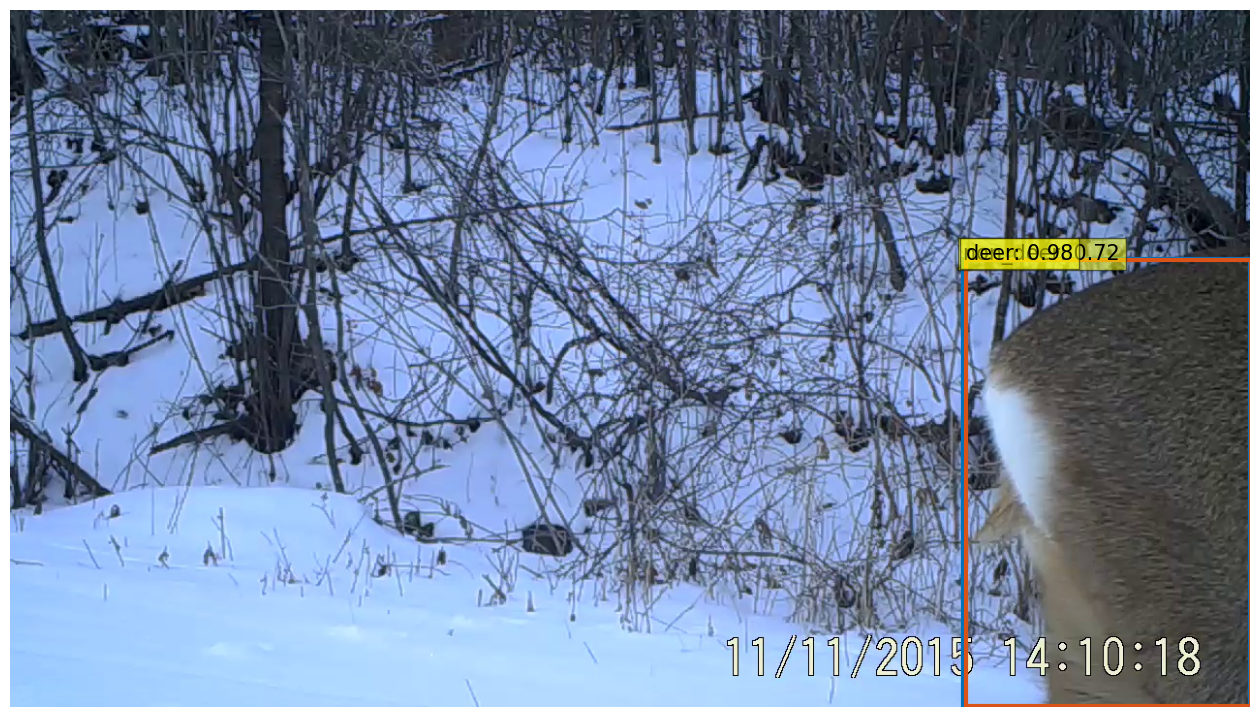

In [27]:
from PIL import Image, ImageDraw
import random

idx = random.randint(0, len(test_dataset))

pixel_values, target = test_dataset[idx]
pixel_values = pixel_values.unsqueeze(0).to(device)
outputs = model(pixel_values=pixel_values)

image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
filepath = os.path.join(data_folder, image['file_name'])
image = Image.open(filepath)

visualize_predictions(image, outputs)